Some help 'cause I need it: https://github.com/krasserm/super-resolution

https://github.com/idealo/image-super-resolution/tree/master/notebooks

In [1]:
import tensorflow as tf

def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]

def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def evaluate(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = resolve(model, lr)
        psnr_value = psnr(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)

def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

In [2]:
import numpy as np

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def normalize(x):
    return (x - DIV2K_RGB_MEAN) / 127.5


def denormalize(x):
    return x * 127.5 + DIV2K_RGB_MEAN

In [3]:
import time

from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay


class Trainer:
    def __init__(self,
                 model,
                 loss,
                 learning_rate,
                 checkpoint_dir='./ckpt/edsr'):

        self.now = None
        self.loss = loss
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              optimizer=Adam(learning_rate),
                                              model=model)
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_dir,
                                                             max_to_keep=3)

        self.restore()

    @property
    def model(self):
        return self.checkpoint.model

    def train(self, train_dataset, valid_dataset, steps, evaluate_every=1000, save_best_only=False):
        loss_mean = Mean()

        ckpt_mgr = self.checkpoint_manager
        ckpt = self.checkpoint

        self.now = time.perf_counter()

        for lr, hr in train_dataset.take(steps - ckpt.step.numpy()):
            ckpt.step.assign_add(1)
            step = ckpt.step.numpy()

            loss = self.train_step(lr, hr)
            loss_mean(loss)

            if step % evaluate_every == 0:
                loss_value = loss_mean.result()
                loss_mean.reset_states()

                # Compute PSNR on validation dataset
                psnr_value = self.evaluate(valid_dataset)

                duration = time.perf_counter() - self.now
                print(f'{step}/{steps}: loss = {loss_value.numpy():.3f}, PSNR = {psnr_value.numpy():3f} ({duration:.2f}s)')

                if save_best_only and psnr_value <= ckpt.psnr:
                    self.now = time.perf_counter()
                    # skip saving checkpoint, no PSNR improvement
                    continue

                ckpt.psnr = psnr_value
                ckpt_mgr.save()

                self.now = time.perf_counter()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.checkpoint.model(lr, training=True)
            loss_value = self.loss(hr, sr)

        gradients = tape.gradient(loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return loss_value

    def evaluate(self, dataset):
        return evaluate(self.checkpoint.model, dataset)

    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')


class EdsrTrainer(Trainer):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5])):
        super().__init__(model, loss=MeanAbsoluteError(), learning_rate=learning_rate, checkpoint_dir=checkpoint_dir)

    def train(self, train_dataset, valid_dataset, steps=300000, evaluate_every=1000, save_best_only=True):
        super().train(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)

In [4]:
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'mild'

In [6]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

In [7]:
from data import DIV2K

div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade, images_dir="./../dataset/", caches_dir="./../dataset/")
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade, images_dir="./../dataset/", caches_dir="./../dataset/")

In [8]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

In [9]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

Model restored from checkpoint at step 1000.


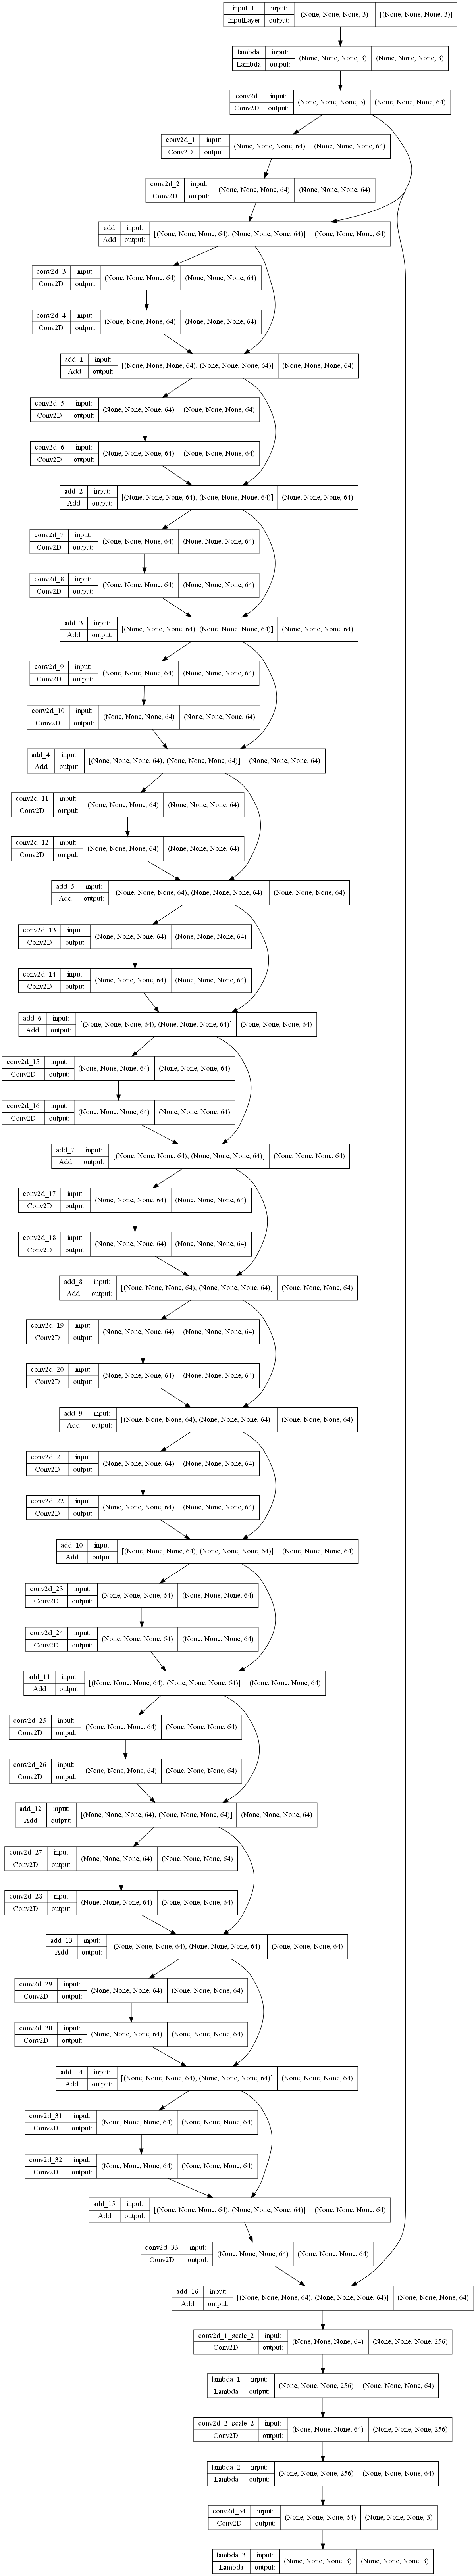

In [30]:
tf.keras.utils.plot_model(trainer.model, show_shapes=True)

In [20]:
trainer.train(train_ds,
              valid_ds.take(10),
              steps=10000, 
              evaluate_every=50, 
              save_best_only=True)

2050/10000: loss = 19.726, PSNR = 20.042223 (12.11s)
2100/10000: loss = 19.881, PSNR = 20.076990 (11.33s)
2150/10000: loss = 19.404, PSNR = 20.040768 (10.86s)
2200/10000: loss = 19.730, PSNR = 20.067644 (10.65s)
2250/10000: loss = 19.903, PSNR = 20.031342 (10.69s)
2300/10000: loss = 20.302, PSNR = 19.982456 (10.70s)
2350/10000: loss = 19.288, PSNR = 20.028118 (10.59s)
2400/10000: loss = 20.031, PSNR = 19.999826 (10.77s)
2450/10000: loss = 19.521, PSNR = 19.963856 (10.63s)
2500/10000: loss = 19.409, PSNR = 20.002962 (10.78s)
2550/10000: loss = 19.533, PSNR = 19.907927 (10.66s)
2600/10000: loss = 20.189, PSNR = 19.935379 (10.79s)
2650/10000: loss = 19.221, PSNR = 19.972744 (10.80s)
2700/10000: loss = 19.891, PSNR = 19.934978 (10.76s)
2750/10000: loss = 19.685, PSNR = 19.986843 (10.82s)
2800/10000: loss = 19.995, PSNR = 20.004189 (10.80s)
2850/10000: loss = 20.159, PSNR = 20.060934 (11.05s)
2900/10000: loss = 19.416, PSNR = 19.942770 (10.66s)
2950/10000: loss = 19.653, PSNR = 20.022680 (1

In [21]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 4950.


In [22]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

PSNR = 18.791502


In [23]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

In [24]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [25]:
from PIL import Image


def load_image(path):
    return np.array(Image.open(path))


def plot_sample(lr, sr):
    plt.figure(figsize=(20, 10))

    images = [lr, sr]
    titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])


In [26]:
def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

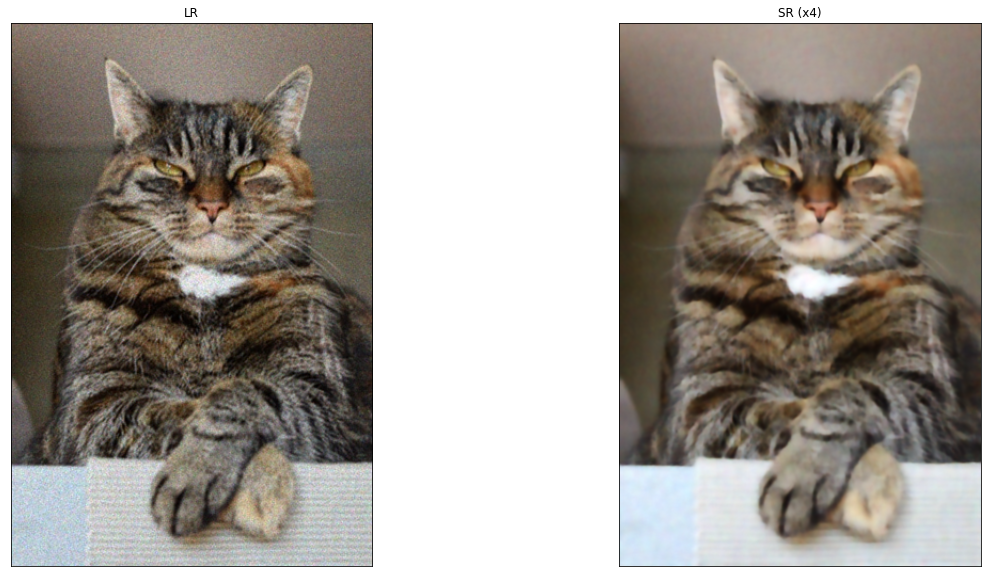

In [27]:
resolve_and_plot('./../dataset/DIV2K_valid_LR_mild/0869x4m.png')

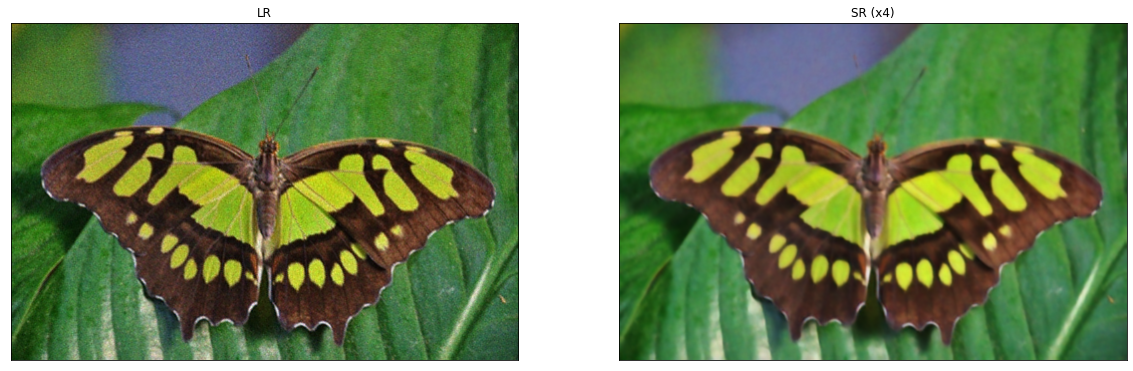

In [28]:
resolve_and_plot('./../dataset/DIV2K_valid_LR_mild/0829x4m.png')

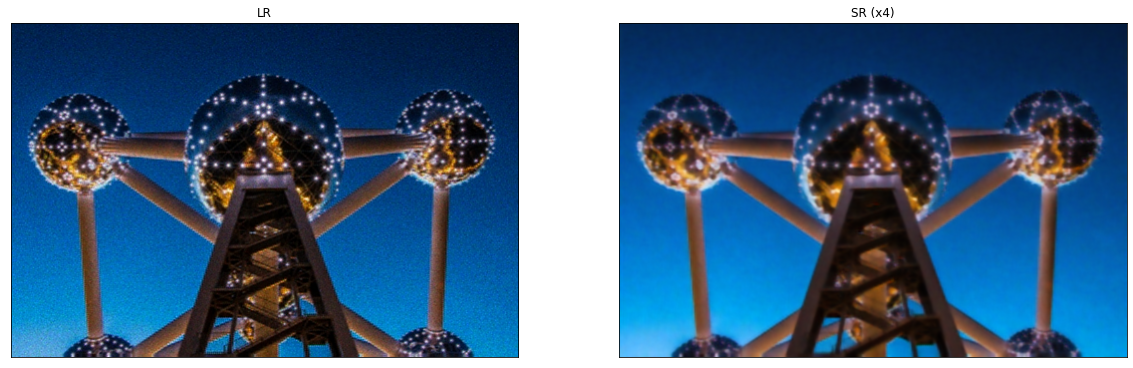

In [29]:
resolve_and_plot('./../dataset/DIV2K_valid_LR_mild/0851x4m.png')